In [ ]:
import torch
import torchvision
print("PyTorch version:", torch.__version__)
print("Torchvision version:", torchvision.__version__)
print("CUDA is available:", torch.cuda.is_available())
import sys
!{sys.executable} -m pip install opencv-python matplotlib
!{sys.executable} -m pip install 'git+https://github.com/facebookresearch/segment-anything.git'

!mkdir images
!wget -P images https://raw.githubusercontent.com/facebookresearch/segment-anything/main/notebooks/images/dog.jpg
    
!wget https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth

In [1]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import cv2

In [2]:
def show_anns(anns):
    if len(anns) == 0:
        return
    sorted_anns = sorted(anns, key=(lambda x: x['area']), reverse=True)
    ax = plt.gca()
    ax.set_autoscale_on(False)

    img = np.ones((sorted_anns[0]['segmentation'].shape[0], sorted_anns[0]['segmentation'].shape[1], 4))
    img[:,:,3] = 0
    for ann in sorted_anns:
        m = ann['segmentation']
        color_mask = np.concatenate([np.random.random(3), [0.35]])
        img[m] = color_mask
    ax.imshow(img)

In [3]:
image = cv2.imread('images/dog.jpg')
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

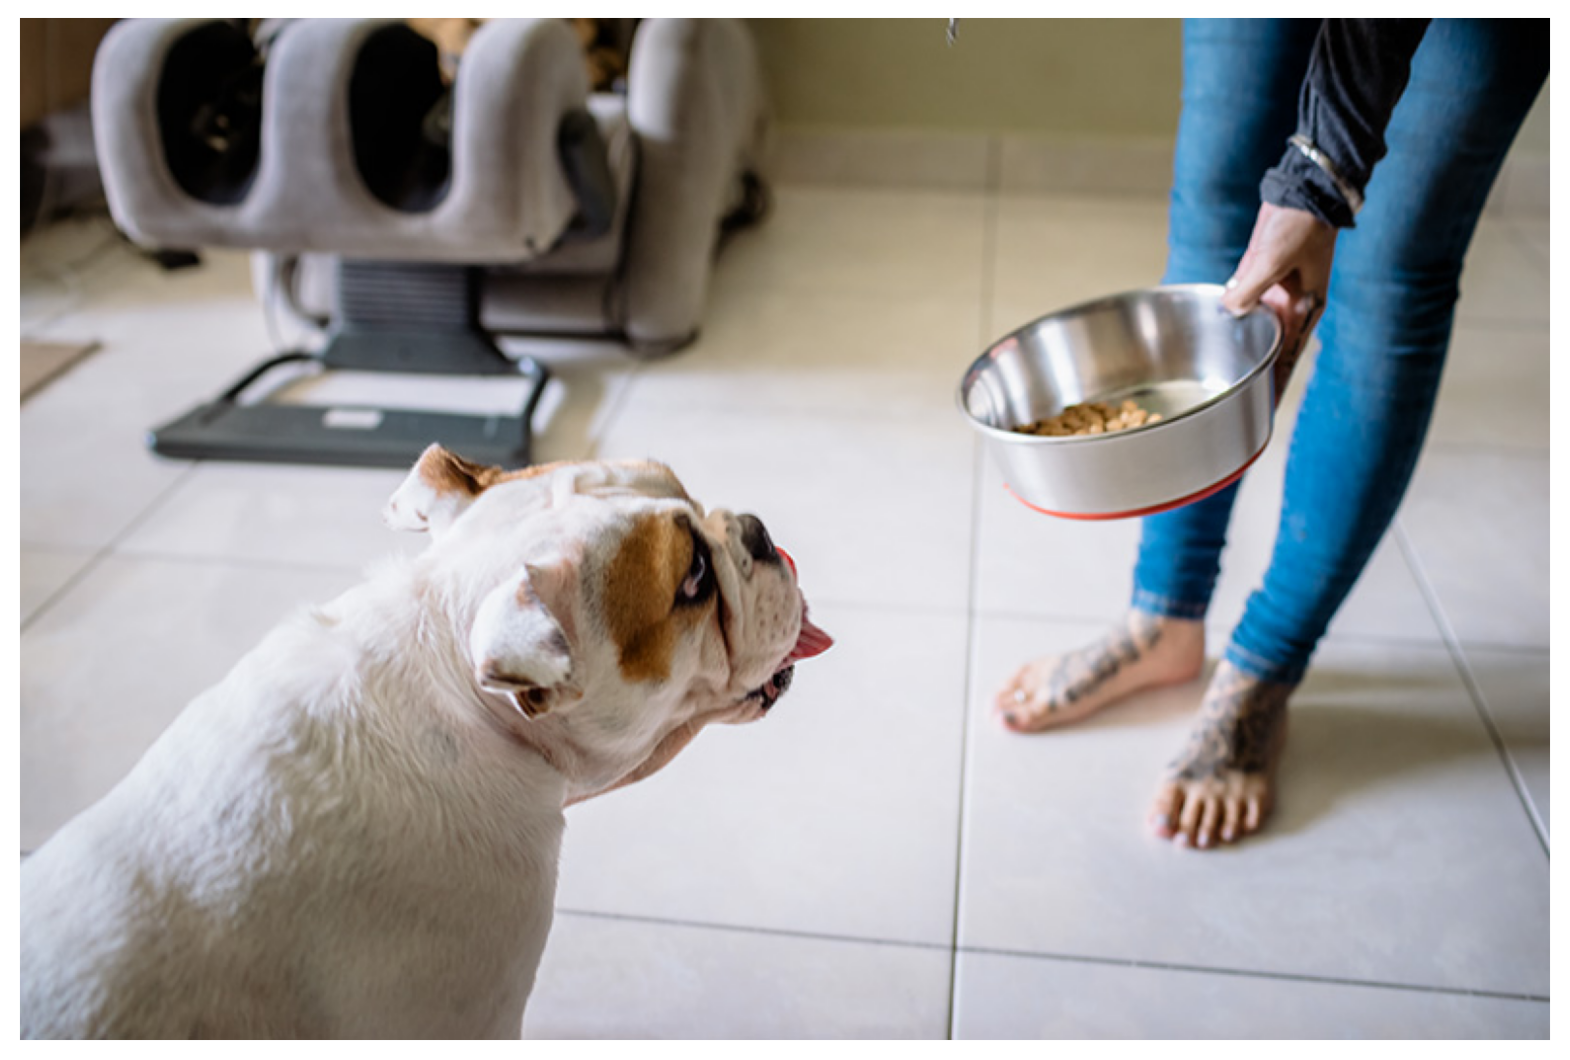

In [4]:
plt.figure(figsize=(20,20))
plt.imshow(image)
plt.axis('off')
plt.show()

In [6]:
import sys
sys.path.append("..")
from segment_anything import sam_model_registry, SamAutomaticMaskGenerator, SamPredictor

sam_checkpoint = "checkpoints/sam_vit_h_4b8939.pth"
model_type = "vit_h"

device = "cuda"

sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
sam.to(device=device)

mask_generator = SamAutomaticMaskGenerator(sam)

/home/disi/miniconda3/lib/python3.10/site-packages/segment_anything/build_sam.py:105: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(f)


In [7]:
masks = mask_generator.generate(image)

In [8]:
print(len(masks))
print(masks[0].keys())

66
dict_keys(['segmentation', 'area', 'bbox', 'predicted_iou', 'point_coords', 'stability_score', 'crop_box'])


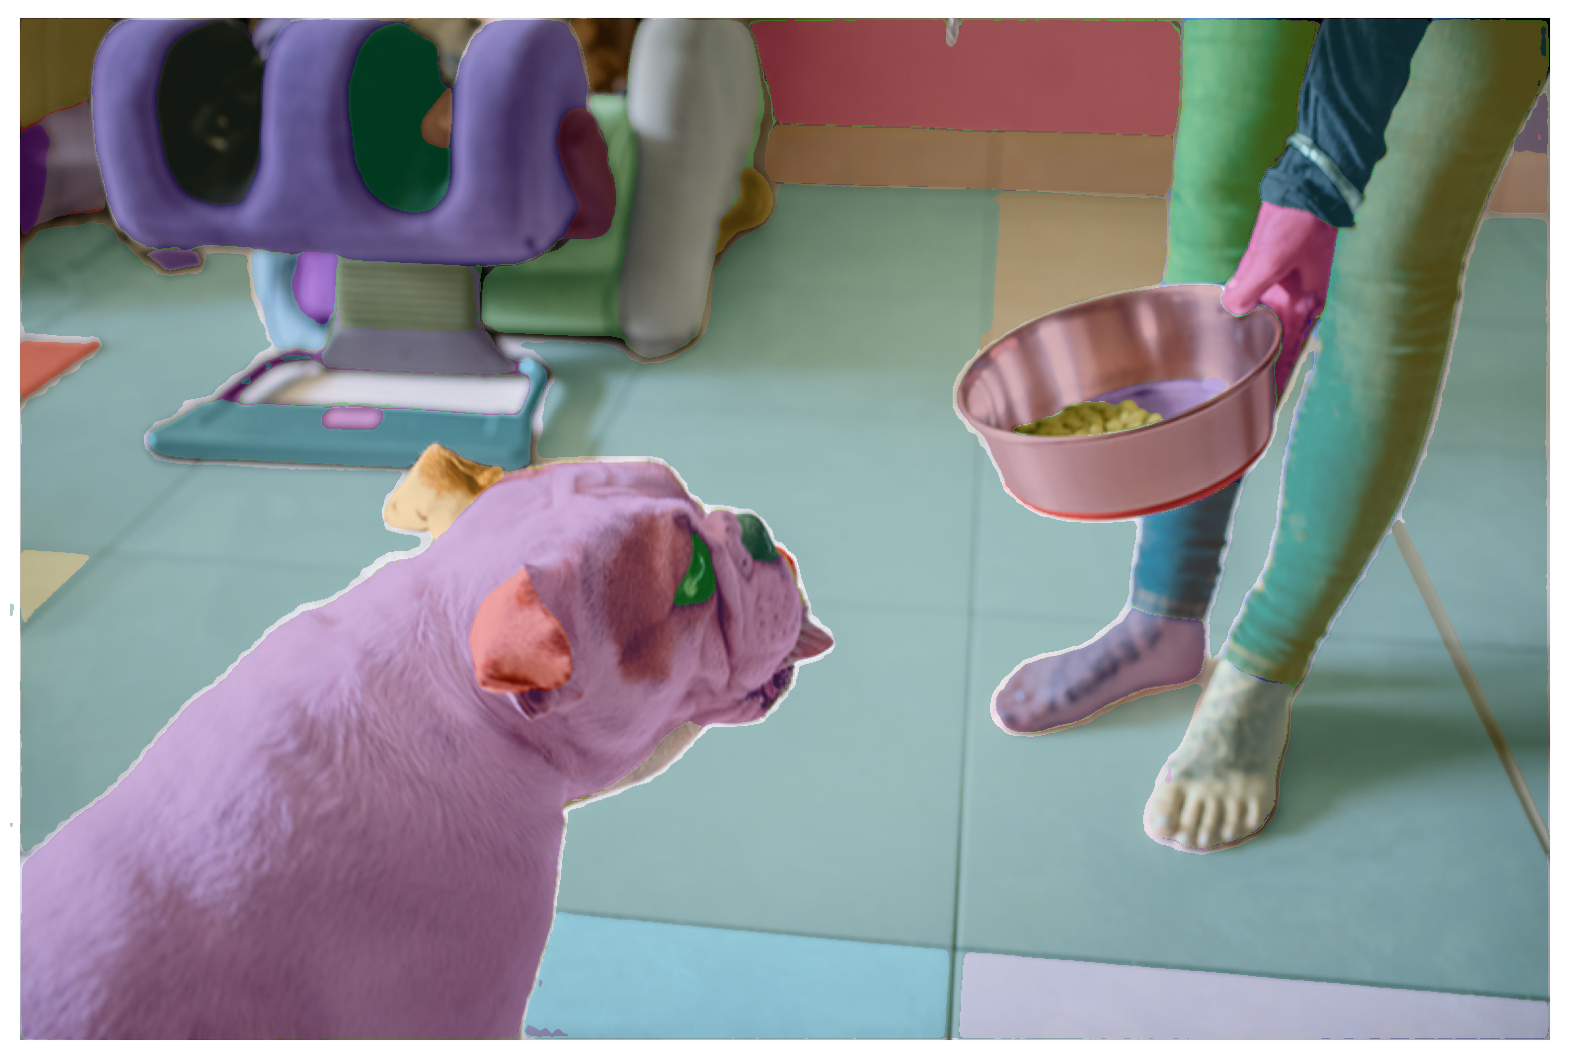

In [9]:
plt.figure(figsize=(20,20))
plt.imshow(image)
show_anns(masks)
plt.axis('off')
plt.show() 

In [46]:
mask_generator_2 = SamAutomaticMaskGenerator(
    model=sam,
    points_per_side=4,
    pred_iou_thresh=0.86,
    stability_score_thresh=0.92,
    crop_n_layers=0,
    crop_n_points_downscale_factor=2,
    min_mask_region_area=100,  # Requires open-cv to run post-processing
)

In [47]:
masks2 = mask_generator_2.generate(image)

In [50]:
len(masks2)

11

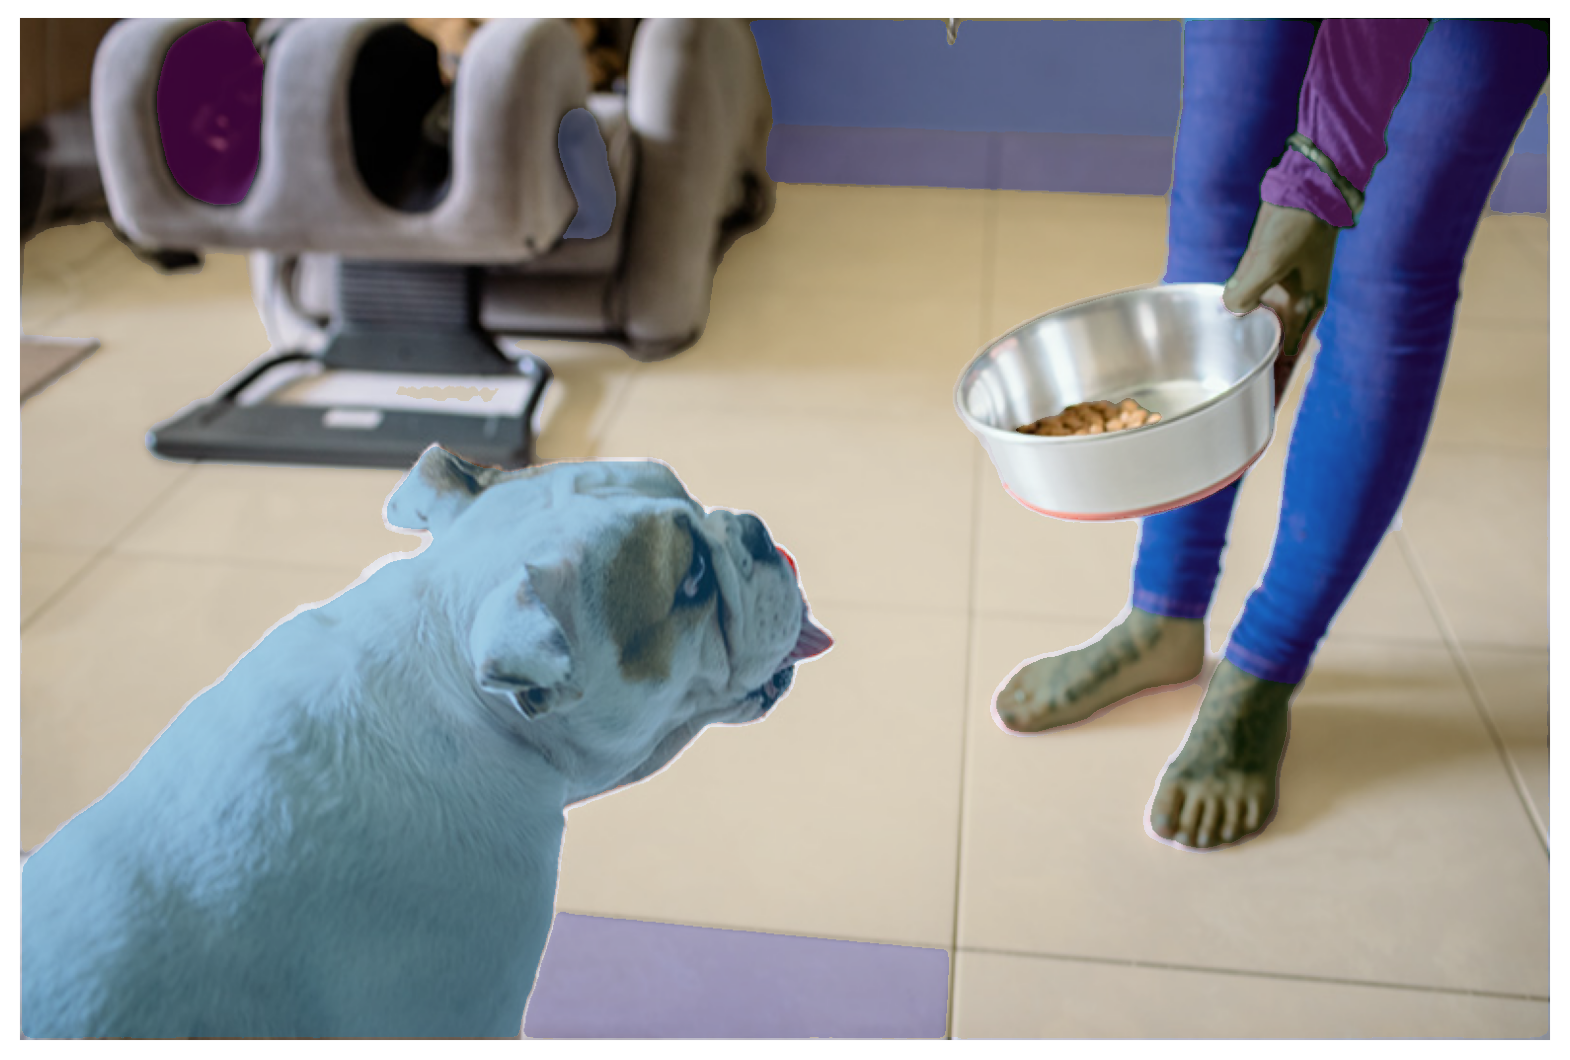

In [51]:
plt.figure(figsize=(20,20))
plt.imshow(image)
show_anns(masks2)
plt.axis('off')
plt.show() 

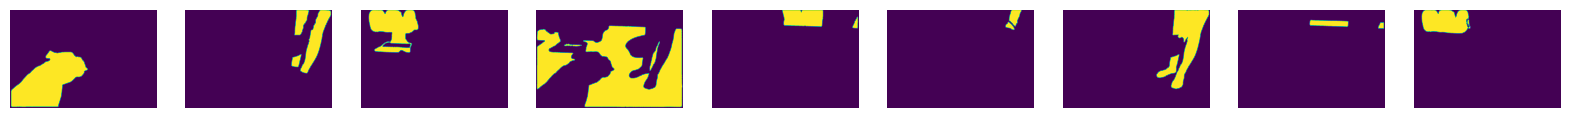

In [35]:
# Create a smaller subplot showing every mask in separate images
fig, axs = plt.subplots(1, len(masks2), figsize=(20,20))
for i, mask in enumerate(masks2):
    axs[i].imshow(mask['segmentation'])
    axs[i].axis('off')
plt.show()

In [40]:
masks[0]['bbox']


[12, 443, 816, 598]

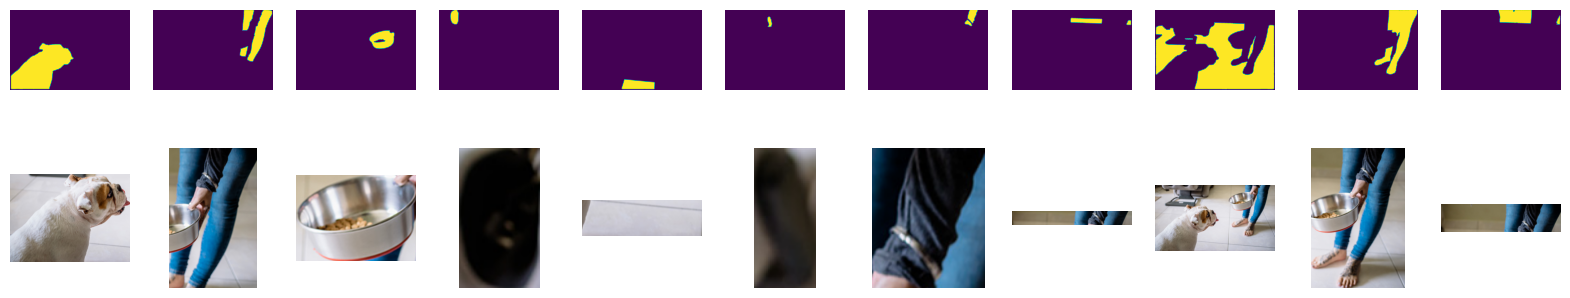

In [52]:
fig, axs = plt.subplots(2, len(masks2), figsize=(20,4))
for i, mask in enumerate(masks2):
    x, y, w, h = mask['bbox']
    axs[0, i].imshow(mask['segmentation'])
    axs[0, i].axis('off')
    axs[1, i].imshow(image[y:y+h, x:x+w])
    axs[1, i].axis('off')
plt.show()

## Next
Feed this to CLIP for classification given a set of classes.